<a href="https://colab.research.google.com/github/vibha-rajan/check/blob/master/fine_tuning_mrpc_with_blurr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr
!pip install -Uqq wandb

     |████████████████████████████████| 2.6 MB 9.6 MB/s 
     |████████████████████████████████| 542 kB 65.6 MB/s 
     |████████████████████████████████| 76 kB 6.8 MB/s 
     |████████████████████████████████| 3.3 MB 53.7 MB/s 
     |████████████████████████████████| 636 kB 60.7 MB/s 
     |████████████████████████████████| 895 kB 77.4 MB/s 
     |████████████████████████████████| 243 kB 71.0 MB/s 
     |████████████████████████████████| 118 kB 69.4 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 16.1 MB/s 
     |████████████████████████████████| 43 kB 2.9 MB/s 
     |████████████████████████████████| 188 kB 38.7 MB/s 
     |████████████████████████████████| 53 kB 3.1 MB/s 
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 138 kB 35.1 MB/s 
     |████████████████████████████████| 133 kB 38.4 MB/s 
     |████████████████████████████████| 170 kB 41.4 MB/s 
     |██████████████████

# Fine-tuning with ***Blurr***

***Blurr*** is a fastai-centric library that allows developers to train and deploy Hugging Face transformers using fastai.  

My design objectives are simple:

**1. fast.ai first!** \
The library is designed to be familiar to folks who have taken the online course or made it throught the first few chapters of the Fastbook. The same steps you take to train a CNN are the same steps you'll follow to train a transformer.

**2. Support core tasks out-of-the-box with any transformer architecture** \
Blurr supports causal/masked language modeling, sequence classification, token classification, extrative Q&A, summarization, and translation tasks using almost any transformer architecture out-of-the-box. Very rarely, if ever, will you have to create your own callbacks or transforms regardless what architecture you choose.  This makes running experiments over multiple models trivial, allowing you to iterate over different architectures to find the one that works best for your specific dataset.

**3. Flexible and extendable** \
And just in case Blurr doesn't have what you need ... folks can replace or extend any of the callbacks and transforms used in the library as needed.  Just like with fastai, you can use it as is or customize it to your heart's content.

In [ ]:
import wandb

from fastai.text.all import *
from fastai.callback.wandb import *

from datasets import load_dataset, concatenate_datasets
from transformers import AutoModelForSequenceClassification

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock
from blurr.modeling.core import Blearner, HF_BaseModelWrapper, HF_BaseModelCallback, hf_splitter

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Let's set our `model_cls` and `checkpoint` here

In [ ]:
model_cls = AutoModelForSequenceClassification
checkpoint = 'bert-base-uncased' # TIP: try different architectures

bsz, val_bsz = 8, 16 # TIP: training on bigger batch sizes is typically better

wandb_init_kwargs = {
    'reinit': True, 
    'project': "blurr", 
    'entity': "ohmeow",
    'group': 'glue-mrpc',
    'name': 'glue-mrpc-bert-base-uncased',  
    'notes': 'Finetuning glue-mrpc with Blurr', 
    'tags': ['bert', 'glue-mrpc', 'blurr']
  }

## Using the low/mid-level API

In [ ]:
raw_datasets = load_dataset('glue', 'mrpc') 
print(f'{raw_datasets}\n')
print(f'{raw_datasets["train"][0]}\n')
print(f'{raw_datasets["train"].features}\n')

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}

{'sentence1': Value(dtype='string', id=None), 'sentence2': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_f

### Data preparation

In [ ]:
n_train, n_valid = raw_datasets['train'].num_rows, raw_datasets['validation'].num_rows
train_idxs, valid_idxs = L(range(n_train)), L(range(n_train, n_train + n_valid))
raw_ds = concatenate_datasets([raw_datasets['train'], raw_datasets['validation']])

In [ ]:
n_lbls = len(set([item['label'] for item in raw_ds])); n_lbls

2

With are raw data fetched, we can get our Hugging Face objects, construct our `DataBlock`, and finally build our `DataLoaders` from it

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(checkpoint, model_cls=model_cls, config_kwargs={'num_labels': n_lbls})

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())

dblock = DataBlock(blocks=blocks, 
                   get_x=itemgetter('sentence1', 'sentence2'),
                   get_y=itemgetter('label'), 
                   splitter=IndexSplitter(valid_idxs))

In [ ]:
dls = dblock.dataloaders(raw_ds, bs=bsz, val_bs=val_bsz)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=5)

,text,category
0,"with claritin's decline, schering - plough's best - selling products now are two drugs used together to treat hepatitis c, the antiviral pill ribavirin and an interferon medicine called peg - intron. with claritin's decline, schering - plough's best - selling products are now antiviral drug ribavirin and an interferon medicine called peg - intron - - two drugs used together to treat hepatitis c.",1
1,"the updated 64 - bit operating system, windows xp 64 - bit edition for 64 - bit extended systems, will run natively on amd athlon 64 processor - powered desktops and amd opteron processor - powered workstations. windows xp 64 - bit edition for 64 - bit extended systems will support amd64 technology, running natively on amd athlon 64 powered desktops and amd opteron processor - powered workstations.",1
2,media giant vivendi universal eaug. pa v. n set to work sifting through bids for its u. s. entertainment empire on monday in a multibillion - dollar auction of some of hollywood's best - known assets. media moguls jostled for position as the deadline for bids for vivendi universal's u. s. entertainment empire neared on monday in an auction of some of hollywood's best - known assets.,1
3,"aside from meeting chinese premier wen jiabao on the sidelines of the forum, mr goh also met pakistani president pervez musharraf and tajikistan president emomali sharipovich rakhmonov. on the sidelines of the bo'ao forum, mr goh also met pakistani president pervez musharraf and held talks with tajikistan president emomali sharipovich rakhmonov.",0
4,"three such vigilante - style attacks forced the hacker organizer, who identified himself only as "" eleonora67, "" to extend the contest until 6 p. m. edt sunday. three such vigilante - style attacks forced the hacker organizer, who identified himself only as "" eleonora [ 67 ], "" to extend the contest until 3 p. m. arizona time sunday.",1


### Train

In [ ]:
wandb.init(**wandb_init_kwargs)

wandb: Currently logged in as: ohmeow (use `wandb login --relogin` to force relogin)


If you want to use your neighborhood friendly out-of-the-box fastai `Learner`, you can ...

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=Adam,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, F1Score()],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.freeze()

... ***BUT*** we can also use a `Blearner` (pronouned 'Blurr-ner').  This returns a `Learner` with sensible defaults given your `DataLoaders` and `hf_model` with the ability to customize as needed)

In [ ]:
learn = Blearner(dls, hf_model, metrics=[accuracy, F1Score()])
learn.unfreeze() # TIP: Experiment with gradual unfreezing; sometimes it helps ... sometimes not so much

From here you have the entire fastai toolset at your disposal

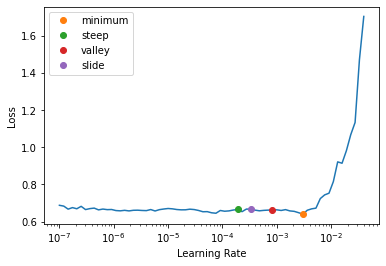

In [ ]:
lr_res = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
# TIP: experiment with different LRs and epochs; what did the authors use?
learn.fit_one_cycle(3, lr_max=5e-5, cbs=[WandbCallback(log_preds=False, log_model=False)]) 

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.490254,0.381469,0.835784,0.877514,00:57
1,0.296461,0.321337,0.870098,0.905861,00:59
2,0.077418,0.461062,0.860294,0.901893,01:01


In [ ]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"he said the foodservice pie business doesn't fit the company's long - term growth strategy. "" the foodservice pie business does not fit our long - term growth strategy.",1,1
1,"mccabe said he was considered a witness, not a suspect. "" he is not considered a suspect, "" mccabe said.",0,1
2,the 12 - nation currency has risen by 33 percent against the dollar over the past 15 months. the euro is up 9 percent against the dollar in the past six weeks.,1,1
3,"some of the company's software developers will join microsoft, but details haven't been finalized, said mike nash, corporate vice president of microsoft's security business unit. some of the companys software developers will join microsoft, but details havent been finalized, said mike nash, corporate vice president of microsofts security business unit.",1,1
4,"in february 2000, the officers — kenneth boss, sean carroll, edward mcmellon and richard murphy — were acquitted of all charges in the killing. the officers - - kenneth boss, sean carroll, edward mcmellon and richard murphy - - were acquitted in 2000 of state murder charges.",1,1


### Evaluate

In [ ]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'accuracy': 0.8602941036224365,
 'f1_score': 0.9018932874354562,
 'loss': 0.4610615670681}

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([408, 2]) torch.Size([408]) torch.Size([408])
TensorBase(0.4611) TensorBase(0.8603)


In [ ]:
wandb.finish()

epoch,3
train_loss,0.07742
raw_loss,0.0336
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█████▇▇▇▆▆▇▆▆▆▅▅▄▄▄▄▄▄▄▄▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁
raw_loss,▇▇█▇▆▄▆▅█▇▆▅▃█▃▆▄▄▃▁▂▄▂▁▃▂▁▁▁▂▁▄▄▁▁▂▁▁▄▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


### Inference

In [ ]:
learn.export('mrpc_learner.pkl')

In [ ]:
inf_learn = load_learner('mrpc_learner.pkl')

**Item inference** on one or more items

In [ ]:
inf_learn.blurr_predict({'sentence1': 'this is looking really great', 'sentence2': 'Dogs are better than cats!!!'})

[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9819, 0.0181])])]

In [ ]:
inf_learn.blurr_predict([
                         {'sentence1': 'this is looking really great', 'sentence2': 'Dogs are better than cats!!!'},
                         {'sentence1': 'Dogs are the best', 'sentence2': 'Dogs are better than cats!!!'}
                        ])

[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9819, 0.0181])]),
 (('1',), (#1) [tensor(1)], (#1) [tensor([0.0931, 0.9069])])]

**Batch inference** over our entire dataset

In [ ]:
test_dl = inf_learn.dls.test_dl(raw_datasets['test'].select(range(100)))
preds = inf_learn.get_preds(dl=test_dl)
preds[0][:10]

tensor([[0.0013, 0.9987],
        [0.0047, 0.9953],
        [0.0012, 0.9988],
        [0.5784, 0.4216],
        [0.9840, 0.0160],
        [0.0012, 0.9988],
        [0.8781, 0.1219],
        [0.5090, 0.4910],
        [0.0218, 0.9782],
        [0.9889, 0.0111]])

## Using the high-level API

In [ ]:
from blurr.modeling.core import BlearnerForSequenceClassification

Let's use a `DataFrame` this time.  

One of the reasons I typically choose `DataFrames` as the format for my raw data is because they are ubiquitous.  You can source them from a .csv, .xls/x, .json, sql, etc..., which make them quite handy reqardless of where your raw data is coming from.

In [ ]:
raw_datasets = load_dataset('glue', 'mrpc') 

train_df = raw_datasets['train'].to_pandas()
train_df['is_valid'] = False

valid_df = raw_datasets['validation'].to_pandas()
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [ ]:
wandb.init(**wandb_init_kwargs)

In [ ]:
learn = BlearnerForSequenceClassification.from_dataframe(df, checkpoint, text_attr=['sentence1', 'sentence2'], label_attr='label', 
                                                         dl_kwargs={'bs': bsz, 'val_bs': val_bsz})

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=5e-5, cbs=[WandbCallback(log_preds=False, log_model=False)])

Could not gather input dimensions


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.502194,0.393293,0.879599,0.823529,00:59
1,0.289028,0.404690,0.896211,0.845588,01:00
2,0.074318,0.441069,0.897959,0.852941,01:00


In [ ]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"he said the foodservice pie business doesn't fit the company's long - term growth strategy. "" the foodservice pie business does not fit our long - term growth strategy.",1,1
1,"spansion products are to be available from both amd and fujitsu, amd said. spansion flash memory solutions are available worldwide from amd and fujitsu.",1,1
2,"north american markets grabbed early gains monday morning, as earnings season begins to slow and economic indicators take the spotlight. north american futures pointed to a strong start to the first trading session of the week monday, as earnings season slows and economic indicators take the spotlight.",1,1
3,the attack followed several days of disturbances in the city where american soldiers exchanged fire with an unknown number of attackers as civilians carried out demonstrations against the american presence. the attack came after several days of disturbance in the city in which u. s. soldiers exchanged fire with an unknown number of attackers as civilians protested the american presence.,1,1
4,"sales for the quarter beat expectations, rising 37 percent year - on - year to 1. 76 billion euros. sales rose 37 per cent year - on - year to 1. 76bn, beating expectations.",1,1


Inference works this same as above ...

In [ ]:
learn.export('mrpc_learner2.pkl')

In [ ]:
inf_learn2 = load_learner('mrpc_learner2.pkl')

In [ ]:
print(df[['sentence1', 'sentence2']].iloc[0])
inf_learn2.blurr_predict(df.iloc[0])

sentence1            Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
sentence2    Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
Name: 0, dtype: object


[(('1',), (#1) [tensor(1)], (#1) [tensor([0.0096, 0.9904])])]

In [ ]:
inf_learn2.blurr_predict([L('I love cats', 'I kind of like cats')])

[(('1',), (#1) [tensor(1)], (#1) [tensor([0.0407, 0.9593])])]

In [ ]:
test_df = (raw_datasets['test'].select(range(100))).to_pandas()

test_dl = inf_learn2.dls.test_dl(test_df)
preds = inf_learn2.get_preds(dl=test_dl)
preds[0][:10]

tensor([[0.0451, 0.9549],
        [0.4321, 0.5679],
        [0.0018, 0.9982],
        [0.0274, 0.9726],
        [0.9899, 0.0101],
        [0.0017, 0.9983],
        [0.9807, 0.0193],
        [0.9845, 0.0155],
        [0.0075, 0.9925],
        [0.9764, 0.0236]])

In [ ]:
wandb.finish()

epoch,3
train_loss,0.07432
raw_loss,0.01594
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█████▇▇▇▇▇▆▆▆▆▆▅▄▄▄▄▄▄▄▄▄▄▄▃▂▂▂▁▂▁▁▁▁▁▁▁
raw_loss,▄▅▅▅▆▄▅▄▅▄▅▅▄▄▂▄▂▂▃▂▂▅▁▃▂▃▂▁▁▅▁▁█▁▁▁▁▄▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
